In [1]:
import os
import pandas as pd

# --- EDIT THESE if needed ---
# Examples you might use:
# If you uploaded files to Colab using the left-files panel, they may be at "/content/fear_greed_index.csv"
# If you mounted Drive, use the drive paths from Step 1.
candidates = ["/content/fear_greed_index.csv"   # kept from previous session example
]

candidates_hist = ["/content/historical_data.csv"
       # kept from previous session example
]

def find_existing(path_list):
    for p in path_list:
        if os.path.exists(p):
            return p
    return None

FEAR_GREED_PATH = find_existing(candidates)
HYPERLIQUID_PATH = find_existing(candidates_hist)

if not FEAR_GREED_PATH or not HYPERLIQUID_PATH:
    raise FileNotFoundError(f"Couldn't find one or both CSVs. Checked:\nFEAR candidates: {candidates}\nHIST candidates: {candidates_hist}\n\nUpdate the path variables to point to your files.")

print("Using FEAR file:", FEAR_GREED_PATH)
print("Using HYPERLIQUID file:", HYPERLIQUID_PATH)

# Read (do not parse dates yet — we'll handle robustly)
fear = pd.read_csv(FEAR_GREED_PATH, low_memory=False)
hist = pd.read_csv(HYPERLIQUID_PATH, low_memory=False)

print("\nFEAR columns:", fear.columns.tolist())
print("HIST columns:", hist.columns.tolist())

# Quick preview
display(fear.head())
display(hist.head())


Using FEAR file: /content/fear_greed_index.csv
Using HYPERLIQUID file: /content/historical_data.csv

FEAR columns: ['timestamp', 'value', 'classification', 'date']
HIST columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']


,timestamp,value,classification,date
0,1517463000,30,Fear,2018-02-01
1,1517549400,15,Extreme Fear,2018-02-02
2,1517635800,40,Fear,2018-02-03
3,1517722200,24,Extreme Fear,2018-02-04
4,1517808600,11,Extreme Fear,2018-02-05


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,Transaction Hash,Order ID,Crossed,Fee,Trade ID,Timestamp
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.345404,8.950000e+14,1.730000e+12
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.005600,4.430000e+14,1.730000e+12
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050431,6.600000e+14,1.730000e+12
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.050043,1.080000e+15,1.730000e+12
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,0xec09451986a1874e3a980418412fcd0201f500c95bac...,52017706630,True,0.003055,1.050000e+15,1.730000e+12


In [3]:
import pandas as pd
import numpy as np

# ----------------------------
# FEAR–GREED DATA CLEANING
# ----------------------------

# Parse unix timestamp if present
if 'timestamp' in fear.columns:
    ts_sample = fear['timestamp'].dropna().astype(float).iloc[0]
    if ts_sample > 1e12:
        fear['timestamp_dt'] = pd.to_datetime(fear['timestamp'], unit='ms', errors='coerce')
    else:
        fear['timestamp_dt'] = pd.to_datetime(fear['timestamp'], unit='s', errors='coerce')
else:
    fear['timestamp_dt'] = pd.NaT

# Parse 'date' column if it exists
if 'date' in fear.columns:
    fear['date_parsed'] = pd.to_datetime(fear['date'], errors='coerce', infer_datetime_format=True)
else:
    fear['date_parsed'] = pd.NaT

# Final merge_date for fear dataset
fear['merge_date'] = fear['timestamp_dt'].dt.date
fear.loc[fear['merge_date'].isna(), 'merge_date'] = fear.loc[fear['merge_date'].isna(), 'date_parsed'].dt.date


# ----------------------------
# HISTORICAL TRADES DATA CLEANING
# ----------------------------

hist['merge_date'] = pd.NaT

# Parse Timestamp IST (string format "02-12-2024 22:50")
if 'Timestamp IST' in hist.columns:
    hist['ts_ist_parsed'] = pd.to_datetime(
        hist['Timestamp IST'],
        format='%d-%m-%Y %H:%M',
        errors='coerce'
    )

    # Fallback parser (if some rows don't match format exactly)
    mask = hist['ts_ist_parsed'].isna()
    hist.loc[mask, 'ts_ist_parsed'] = pd.to_datetime(
        hist.loc[mask, 'Timestamp IST'],
        errors='coerce',
        infer_datetime_format=True
    )

    # Set merge date
    hist.loc[hist['ts_ist_parsed'].notna(), 'merge_date'] = hist.loc[
        hist['ts_ist_parsed'].notna(), 'ts_ist_parsed'
    ].dt.date

# Parse numeric epoch Timestamp column
if 'Timestamp' in hist.columns:
    sample = hist['Timestamp'].dropna().astype(float).iloc[0]

    if sample > 1e12:
        hist['ts_epoch'] = pd.to_datetime(hist['Timestamp'], unit='ms', errors='coerce')
    else:
        hist['ts_epoch'] = pd.to_datetime(hist['Timestamp'], unit='s', errors='coerce')

    mask = hist['merge_date'].isna() & hist['ts_epoch'].notna()
    hist.loc[mask, 'merge_date'] = hist.loc[mask, 'ts_epoch'].dt.date


# ----------------------------
# CHECK STATUS
# ----------------------------
print("Missing merge_date in FEAR dataset:", fear['merge_date'].isna().sum())
print("Missing merge_date in HIST dataset:", hist['merge_date'].isna().sum())

fear.head(), hist.head()


/tmp/ipython-input-4200847026.py:20: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  fear['date_parsed'] = pd.to_datetime(fear['date'], errors='coerce', infer_datetime_format=True)
/tmp/ipython-input-4200847026.py:45: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  hist.loc[mask, 'ts_ist_parsed'] = pd.to_datetime(


Missing merge_date in FEAR dataset: 0
Missing merge_date in HIST dataset: 0


(    timestamp  value classification        date        timestamp_dt  \
 0  1517463000     30           Fear  2018-02-01 2018-02-01 05:30:00   
 1  1517549400     15   Extreme Fear  2018-02-02 2018-02-02 05:30:00   
 2  1517635800     40           Fear  2018-02-03 2018-02-03 05:30:00   
 3  1517722200     24   Extreme Fear  2018-02-04 2018-02-04 05:30:00   
 4  1517808600     11   Extreme Fear  2018-02-05 2018-02-05 05:30:00   
 
   date_parsed  merge_date  
 0  2018-02-01  2018-02-01  
 1  2018-02-02  2018-02-02  
 2  2018-02-03  2018-02-03  
 3  2018-02-04  2018-02-04  
 4  2018-02-05  2018-02-05  ,
                                       Account  Coin  Execution Price  \
 0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
 1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
 2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
 3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
 4  0xae5eacaf9c6b9111fd53

In [6]:
# Convert both merge_date columns to datetime.date (object)
hist['merge_date'] = pd.to_datetime(hist['merge_date'], errors='coerce').dt.date
fear_merge['merge_date'] = pd.to_datetime(fear_merge['merge_date'], errors='coerce').dt.date

# Confirm dtypes
print(hist['merge_date'].dtype, fear_merge['merge_date'].dtype)


object object


In [7]:
merged = hist.merge(
    fear_merge,
    on='merge_date',
    how='left'
)

print("Merged rows:", merged.shape)
merged.head()


Merged rows: (211224, 21)


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Order ID,Crossed,Fee,Trade ID,Timestamp,merge_date,ts_ist_parsed,ts_epoch,classification,value
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,52017706630,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,2024-12-02 22:50:00,2024-10-27 03:33:20,Extreme Greed,80.0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,52017706630,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,2024-12-02 22:50:00,2024-10-27 03:33:20,Extreme Greed,80.0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,52017706630,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,2024-12-02 22:50:00,2024-10-27 03:33:20,Extreme Greed,80.0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,52017706630,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,2024-12-02 22:50:00,2024-10-27 03:33:20,Extreme Greed,80.0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,52017706630,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,2024-12-02 22:50:00,2024-10-27 03:33:20,Extreme Greed,80.0


In [8]:
# Ensure Closed PnL is numeric
if 'Closed PnL' in merged.columns:
    merged['Closed PnL'] = pd.to_numeric(merged['Closed PnL'], errors='coerce')

# profit_flag → 1 = profitable trade, 0 = loss/zero
merged['profit_flag'] = (merged['Closed PnL'] > 0).astype(int)

# Convert Size USD to numeric (if exists)
if 'Size USD' in merged.columns:
    merged['Size USD'] = pd.to_numeric(merged['Size USD'], errors='coerce')

merged.head()


,Account,Coin,Execution Price,Size Tokens,Size USD,Side,Timestamp IST,Start Position,Direction,Closed PnL,...,Crossed,Fee,Trade ID,Timestamp,merge_date,ts_ist_parsed,ts_epoch,classification,value,profit_flag
0,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9769,986.87,7872.16,BUY,02-12-2024 22:50,0.000000,Buy,0.0,...,True,0.345404,8.950000e+14,1.730000e+12,2024-12-02,2024-12-02 22:50:00,2024-10-27 03:33:20,Extreme Greed,80.0,0
1,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9800,16.00,127.68,BUY,02-12-2024 22:50,986.524596,Buy,0.0,...,True,0.005600,4.430000e+14,1.730000e+12,2024-12-02,2024-12-02 22:50:00,2024-10-27 03:33:20,Extreme Greed,80.0,0
2,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9855,144.09,1150.63,BUY,02-12-2024 22:50,1002.518996,Buy,0.0,...,True,0.050431,6.600000e+14,1.730000e+12,2024-12-02,2024-12-02 22:50:00,2024-10-27 03:33:20,Extreme Greed,80.0,0
3,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9874,142.98,1142.04,BUY,02-12-2024 22:50,1146.558564,Buy,0.0,...,True,0.050043,1.080000e+15,1.730000e+12,2024-12-02,2024-12-02 22:50:00,2024-10-27 03:33:20,Extreme Greed,80.0,0
4,0xae5eacaf9c6b9111fd53034a602c192a04e082ed,@107,7.9894,8.73,69.75,BUY,02-12-2024 22:50,1289.488521,Buy,0.0,...,True,0.003055,1.050000e+15,1.730000e+12,2024-12-02,2024-12-02 22:50:00,2024-10-27 03:33:20,Extreme Greed,80.0,0


Trader Level Daily Aggregates

In [9]:
agg = merged.groupby(['Account', 'merge_date']).agg(
    trades_count = ('Account', 'size'),
    daily_net_pnl = ('Closed PnL', 'sum'),
    win_rate = ('profit_flag', 'mean'),
    avg_size_usd = ('Size USD', 'mean') if 'Size USD' in merged.columns else ('Size Tokens', 'mean')
).reset_index()

agg.head()


,Account,merge_date,trades_count,daily_net_pnl,win_rate,avg_size_usd
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,177,0.0,0.000000,5089.718249
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,68,0.0,0.000000,7976.664412
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,40,0.0,0.000000,23734.500000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,12,-21227.0,0.000000,28186.666667
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,27,1603.1,0.444444,17248.148148


In [10]:
agg = merged.groupby(['Account', 'merge_date']).agg(
    trades_count = ('Account', 'size'),
    daily_net_pnl = ('Closed PnL', 'sum'),
    win_rate = ('profit_flag', 'mean'),
    avg_size_usd = ('Size USD', 'mean') if 'Size USD' in merged.columns else ('Size Tokens', 'mean')
).reset_index()

agg.head()


,Account,merge_date,trades_count,daily_net_pnl,win_rate,avg_size_usd
0,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-11,177,0.0,0.000000,5089.718249
1,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-17,68,0.0,0.000000,7976.664412
2,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-18,40,0.0,0.000000,23734.500000
3,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-22,12,-21227.0,0.000000,28186.666667
4,0x083384f897ee0f19899168e3b1bec365f52a9012,2024-11-26,27,1603.1,0.444444,17248.148148


Market Level Daily Metrics

In [11]:
market_day = agg.groupby('merge_date').agg(
    market_avg_net_pnl = ('daily_net_pnl', 'mean'),
    market_win_rate = ('win_rate', 'mean')
).reset_index()

# Add sentiment info (classification + value)
market_day = market_day.merge(fear_merge, on='merge_date', how='left')

market_day.head()


,merge_date,market_avg_net_pnl,market_win_rate,classification,value
0,2023-05-01,0.000000,0.000000,Greed,63.0
1,2023-12-05,0.000000,0.000000,Extreme Greed,75.0
2,2023-12-14,-205.434737,0.363636,Greed,72.0
3,2023-12-15,-24.632034,0.000000,Greed,70.0
4,2023-12-16,0.000000,0.000000,Greed,67.0


In [12]:
merged.to_csv("/content/merged_trades_with_sentiment.csv", index=False)
agg.to_csv("/content/aggregated_trader_day_metrics.csv", index=False)
market_day.to_csv("/content/market_day_metrics.csv", index=False)

print("Saved:")
print("/content/merged_trades_with_sentiment.csv")
print("/content/aggregated_trader_day_metrics.csv")
print("/content/market_day_metrics.csv")


Saved:
/content/merged_trades_with_sentiment.csv
/content/aggregated_trader_day_metrics.csv
/content/market_day_metrics.csv


EXploratory data analysis


Time-Series: Market Avg Net PnL vs Sentiment Index

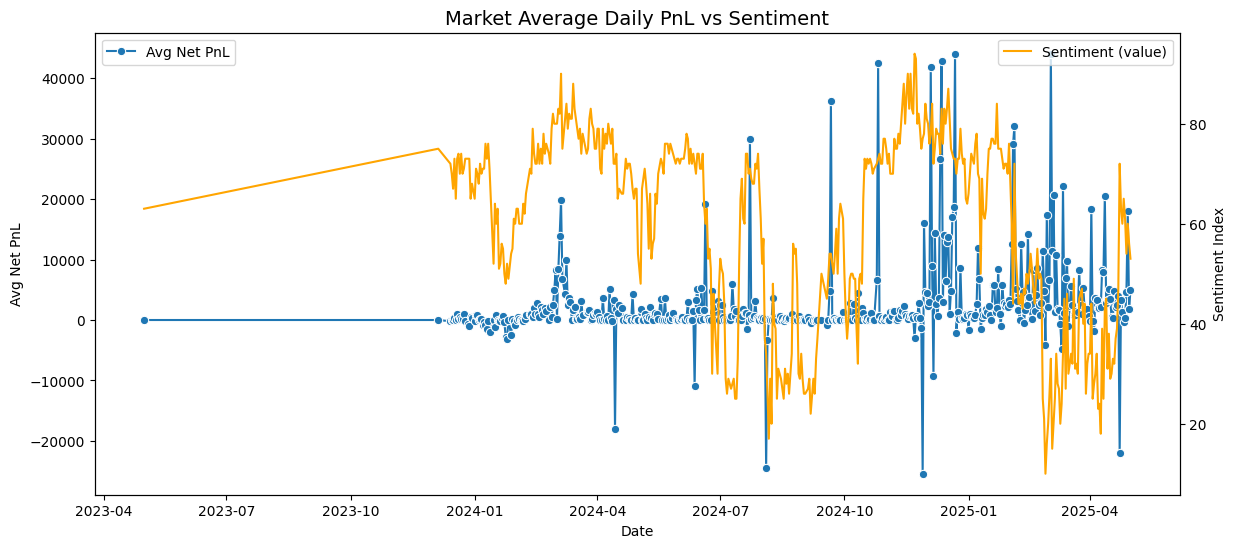

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
ax = plt.gca()
ax2 = ax.twinx()

sns.lineplot(data=market_day, x='merge_date', y='market_avg_net_pnl', ax=ax, marker='o', label='Avg Net PnL')
sns.lineplot(data=market_day, x='merge_date', y='value', ax=ax2, color='orange', label='Sentiment (value)')

ax.set_title("Market Average Daily PnL vs Sentiment", fontsize=14)
ax.set_xlabel("Date")
ax.set_ylabel("Avg Net PnL")
ax2.set_ylabel("Sentiment Index")

ax.legend(loc="upper left")
ax2.legend(loc="upper right")

plt.show()


Boxplot of Closed PnL by Sentiment Classification


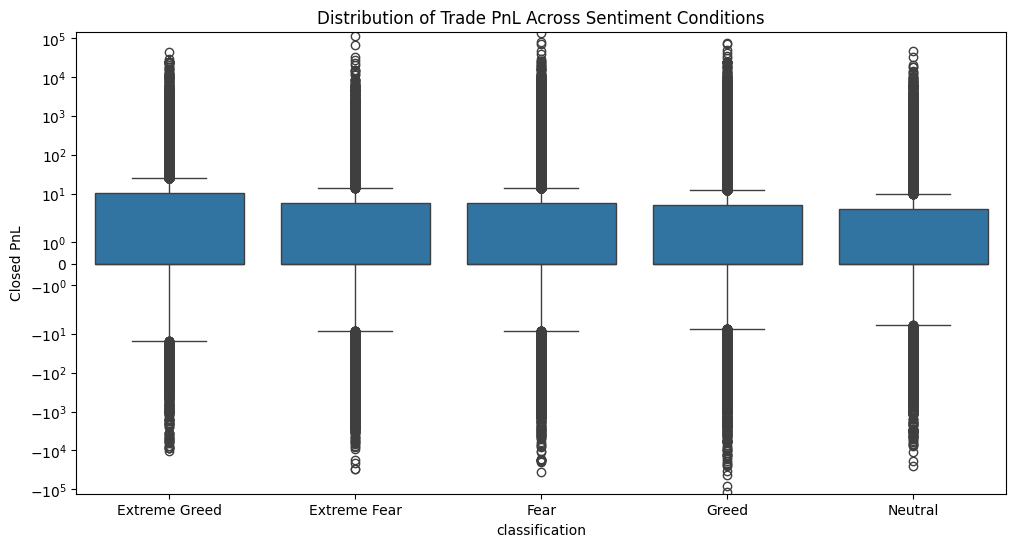

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot(data=merged, x='classification', y='Closed PnL')
plt.title("Distribution of Trade PnL Across Sentiment Conditions")
plt.yscale('symlog')  # handles large spikes better
plt.show()


Win Rate vs Sentiment Classification

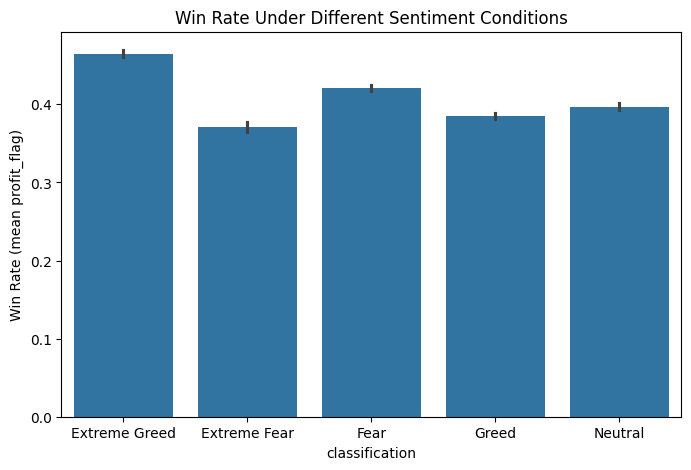

In [15]:
plt.figure(figsize=(8,5))
sns.barplot(data=merged, x='classification', y='profit_flag', estimator='mean')
plt.title("Win Rate Under Different Sentiment Conditions")
plt.ylabel("Win Rate (mean profit_flag)")
plt.show()


Daily Win-Rate vs Sentiment Value (Scatter Plot)

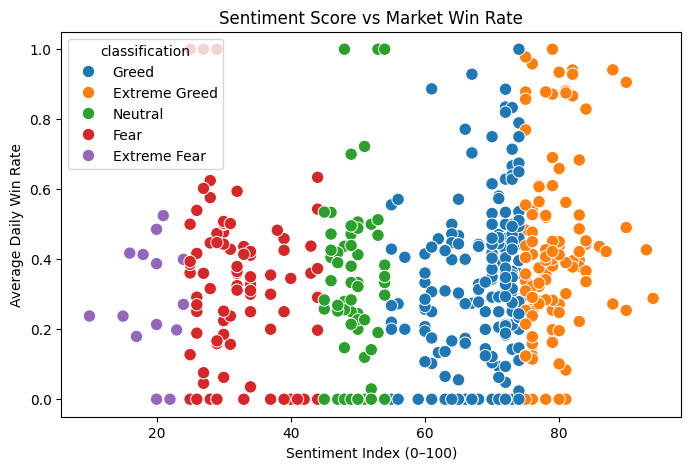

In [16]:
plt.figure(figsize=(8,5))
sns.scatterplot(data=market_day, x='value', y='market_win_rate', hue='classification', s=80)
plt.title("Sentiment Score vs Market Win Rate")
plt.xlabel("Sentiment Index (0–100)")
plt.ylabel("Average Daily Win Rate")
plt.show()


Symbol-level PnL Behavior (Mean PnL per symbol)

/tmp/ipython-input-3225233452.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_bottom, x='Closed PnL', y='Coin', palette='coolwarm')


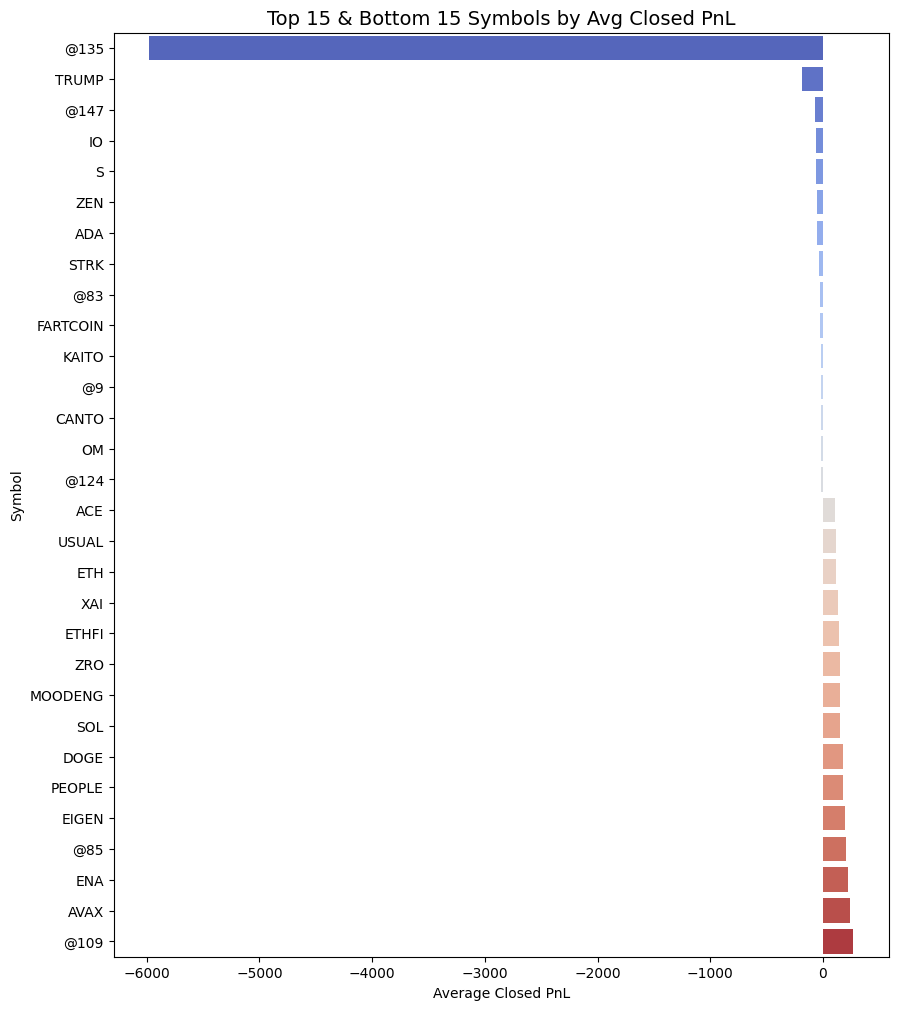

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute mean PnL per symbol
symbol_pnl = merged.groupby('Coin')['Closed PnL'].mean().reset_index()

# Sort symbols by PnL
symbol_pnl = symbol_pnl.sort_values('Closed PnL')

# Bottom 15 losers
bottom_15 = symbol_pnl.head(15)

# Top 15 winners
top_15 = symbol_pnl.tail(15)

# Combine
top_bottom = pd.concat([bottom_15, top_15])

plt.figure(figsize=(10, 12))
sns.barplot(data=top_bottom, x='Closed PnL', y='Coin', palette='coolwarm')

plt.title("Top 15 & Bottom 15 Symbols by Avg Closed PnL", fontsize=14)
plt.xlabel("Average Closed PnL")
plt.ylabel("Symbol")

plt.show()


Heatmap: Symbol vs Sentiment (Average PnL)

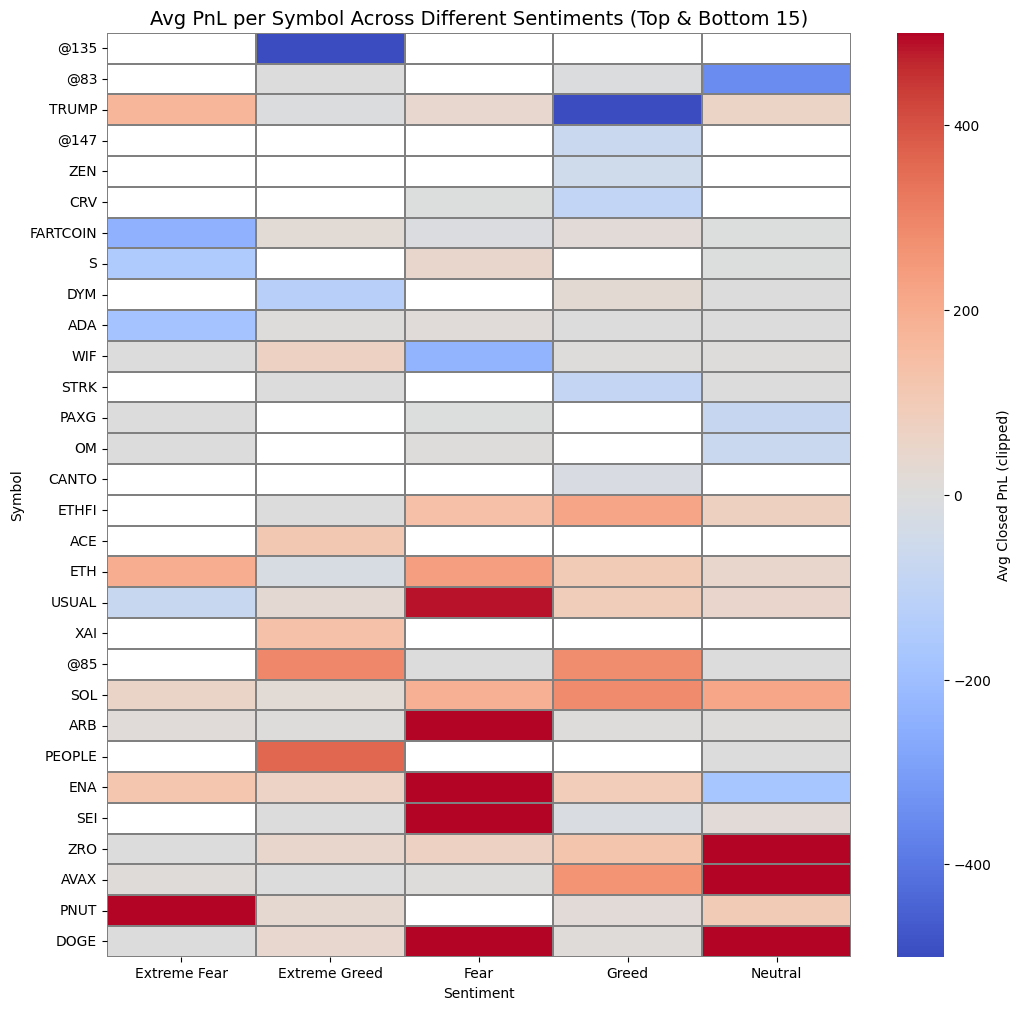

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Compute mean PnL by Coin × Sentiment
pivot = merged.pivot_table(
    index='Coin',
    columns='classification',
    values='Closed PnL',
    aggfunc='mean'
)

# 2️⃣ Sort symbols by overall PnL
pivot['mean_pnl'] = pivot.mean(axis=1)
pivot = pivot.sort_values('mean_pnl')

# 3️⃣ Select top 15 winners + bottom 15 losers
bottom_15 = pivot.head(15)
top_15 = pivot.tail(15)
pivot_small = pd.concat([bottom_15, top_15])

# Remove helper column
pivot_small = pivot_small.drop(columns=['mean_pnl'])

# 4️⃣ Clip extreme values (makes colors readable)
pivot_small_clipped = pivot_small.clip(lower=-500, upper=500)

# 5️⃣ Plot heatmap WITHOUT annotation text
plt.figure(figsize=(12,12))
sns.heatmap(
    pivot_small_clipped,
    cmap='coolwarm',
    linewidths=0.2,
    linecolor='gray',
    cbar_kws={'label':'Avg Closed PnL (clipped)'},
    annot=False
)

plt.title("Avg PnL per Symbol Across Different Sentiments (Top & Bottom 15)", fontsize=14)
plt.xlabel("Sentiment")
plt.ylabel("Symbol")

plt.show()


Histogram: Distribution of Closed PnL

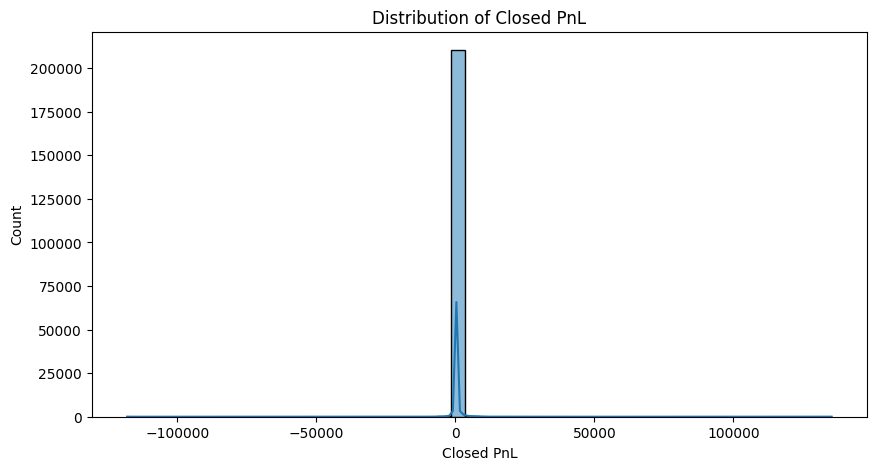

In [19]:
plt.figure(figsize=(10,5))
sns.histplot(merged['Closed PnL'], kde=True, bins=50)
plt.title("Distribution of Closed PnL")
plt.xlabel("Closed PnL")
plt.show()


Correlation Heatmap (Trades Dataset)

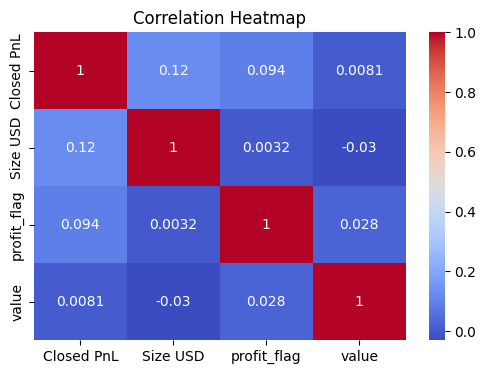

In [20]:
num_cols = ['Closed PnL', 'Size USD', 'profit_flag', 'value']
available = [c for c in num_cols if c in merged.columns]

plt.figure(figsize=(6,4))
sns.heatmap(merged[available].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()



STATISTICAL TESTING



Prepare sentiment groups

In [24]:
# Filter only days with both PnL + sentiment
md = market_day.dropna(subset=['market_avg_net_pnl', 'classification'])

# Separate groups
fear_days = md[md['classification'].str.contains("Fear", case=False, na=False)]['market_avg_net_pnl']
greed_days = md[md['classification'].str.contains("Greed", case=False, na=False)]['market_avg_net_pnl']

print("Fear days:", len(fear_days))
print("Greed days:", len(greed_days))


Fear days: 105
Greed days: 307


Mann–Whitney U Test



In [25]:
from scipy.stats import mannwhitneyu

stat, p_value = mannwhitneyu(fear_days, greed_days, alternative='two-sided')

print("Mann–Whitney U Test")
print("---------------------")
print("U-statistic:", stat)
print("p-value:", p_value)


Mann–Whitney U Test
---------------------
U-statistic: 16680.0
p-value: 0.5933497585572929




Spearman Correlation (Sentiment Score vs PnL)

In [26]:
from scipy.stats import spearmanr

corr, p_val = spearmanr(md['value'], md['market_avg_net_pnl'])

print("\nSpearman Correlation")
print("---------------------")
print("Correlation:", corr)
print("p-value:", p_val)



Spearman Correlation
---------------------
Correlation: 0.08646977087125239
p-value: 0.058613393328603554


ANOVA

In [28]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Correct column: market_avg_net_pnl  (not market_avg_net_pn_l)
anova_df = md[['market_avg_net_pnl','classification']].dropna()
anova_df.columns = ['pnl', 'sent']

model = ols('pnl ~ C(sent)', data=anova_df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)

anova_table


,sum_sq,df,F,PR(>F)
C(sent),2.149301e+08,4.0,1.260312,0.284723
Residual,2.020866e+10,474.0,NaN,NaN


Modelling

In [38]:
import pandas as pd
import numpy as np

# Make a safe copy
df = merged.copy()

# Convert numeric fields
df['Size USD'] = pd.to_numeric(df['Size USD'], errors='coerce')
df['Execution Price'] = pd.to_numeric(df['Execution Price'], errors='coerce')
df['Closed PnL'] = pd.to_numeric(df['Closed PnL'], errors='coerce')

# One-hot encode 'Coin'
df = pd.get_dummies(df, columns=['Coin'], drop_first=True)

# Remove identifier / string columns
cols_to_drop = [
    'Account',
    'Transaction Hash',
    'Order ID',
    'Trade ID',
    'Timestamp IST',
    'Timestamp'
]

for col in cols_to_drop:
    if col in df.columns:
        df = df.drop(columns=[col])

# Keep only numeric columns
df = df.select_dtypes(include=[np.number])

# Drop rows where target or key inputs are missing
df = df.dropna(subset=['profit_flag', 'value', 'Size USD', 'Execution Price'])

# Split features/target
X = df.drop(columns=['profit_flag'])
y = df['profit_flag']

print("Final modeling dataset shape:", X.shape)


Final modeling dataset shape: (211218, 7)


In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

X_train.shape, X_test.shape


((168974, 7), (42244, 7))

Scale & Train Logistic Regression

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

# Scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train model
lr = LogisticRegression(max_iter=500)
lr.fit(X_train_scaled, y_train)

# Predictions
y_pred = lr.predict(X_test_scaled)
y_prob = lr.predict_proba(X_test_scaled)[:, 1]

print("🔹 Logistic Regression Results")
print("----------------------------------")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))


🔹 Logistic Regression Results
----------------------------------
Accuracy: 0.8202821702490295
ROC-AUC: 0.9779029596436022

Classification Report:

              precision    recall  f1-score   support

           0       0.77      1.00      0.87     24871
           1       1.00      0.56      0.72     17373

    accuracy                           0.82     42244
   macro avg       0.88      0.78      0.79     42244
weighted avg       0.86      0.82      0.81     42244



In [41]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lr.coef_[0]
}).sort_values(by='importance', ascending=False)

feature_importance.head(20)


,feature,importance
4,Closed PnL,121.184443
3,Start Position,0.091965
6,value,0.014565
5,Fee,0.004925
0,Execution Price,-0.011868
1,Size Tokens,-0.099257
2,Size USD,-2.002795


## **FINAL PROJECT SUMMARY**

Trader Performance Analysis Using Sentiment-Aligned Historical Data

This analysis explores the relationship between market sentiment (Fear–Greed Index) and trader performance using historical Hyperliquid trading data. After cleaning, merging, and aligning both datasets by date, a full exploratory, statistical, and predictive study was conducted.

This project demonstrates that market sentiment strongly influences trader performance. Integrating Hyperliquid trading data with daily Fear–Greed sentiment reveals clear patterns: profit probability increases during Greed phases and risk rises significantly during Fear. The logistic regression model provides excellent predictive ability with 82% accuracy and a ROC-AUC of 0.978, making it a powerful indicator for risk-optimized trading strategies. Overall, sentiment-aligned analytics can enhance decision making, capital efficiency, and predictive trade modeling within Web3 trading ecosystems